## Collaborative Filtering 
Is where it gets interesting.  The behaviours between users and items; in this case users and patterns are assesed and we can get recommendations like:  Oth 

* Serendipty - help find new patterns wouldn't have looked at before

* Disadvantage - cold start problem. A new pattern or user added to the 

User-User, Item- Item...
"I’m going to go with item-item because it’s generally been found to be more effective, but also because it can immediately make fairly good recommendations to new users (assuming you already have other user reviews in place)."
https://medium.com/@jmcneilkeller/item-item-recommendation-with-surprise-4bf365355d96


There are two types of Collaborative Filtering.
#### Memory Based
In this case I've used K Nearest Neighbours to find item-item similarity. 
(clustering knn model based 

- Disadvantages:  Doesn't perform well with sparse data. 

#### Model Based
Finds latent features through matrix factorization. 

In this case I've used trucated SVD.  Trucated; because when I attempted to perform full SVD on the dataset it was too much for 39 gb RAM on google colab to handle.  SVD is a ...

Implicit Alternating Mean Squares - 

Also tried this out on my own profile for find patterns that match . 

More can be read here:
https://en.m.wikipedia.org/wiki/Collaborative_filtering



In [2]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 17.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606563 sha256=02b2400d6c97f3c21a629c51f7de8a9ba44a67e2b8b1862613f0ded9f65eeda0
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [9]:
# import libraries
import pandas as pd
import numpy as np

# KNN
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Truncated SVD
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# implicit
import implicit
import scipy.sparse as sparse

In [26]:
# load data
# This is to display metadata of the recommended patterns
# pattern_details = pd.read_csv('data/consolidated_patterns.csv', low_memory=False)
pattern_details = pd.read_csv('consolidated_patterns.csv', low_memory=False)

# This is the user/ project/ pattern dataframe, after eliminating any patterns or users below a certain project number threshold
# df = pd.read_csv('data/less_sparse_users_patterns.csv', low_memory=False)
df = pd.read_csv('less_sparse_users_patterns.csv', low_memory=False)

In [27]:
pattern_details.shape, df.shape

((188158, 24), (3250978, 5))

In [13]:
pattern_details.head(2)

,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
0,88,Calorimetry,calorimetry,29838,19426,1.816424,7294.0,4.225295,7895,6618.0,hat,True,https://images4-f.ravelrycache.com/uploads/cas...,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...","['unisex', 'teen', 'adult', 'fitted', 'reversi...",NaN,93.0,2006/12/01 00:00:00 -0500,20.0,4.0,True,True,"['headband', 'headwear', 'accessories']",Aran (8 wpi)
1,3156,Basic Ribbed Socks,basic-ribbed-socks,17795,10987,2.435581,2670.0,4.455242,3519,2480.0,socks,True,https://images4-g.ravelrycache.com/uploads/pie...,"[{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...","['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,370.0,2006/04/01 00:00:00 -0500,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)


In [25]:
# pattern_details.info()

In [28]:
df.head()

,user_id,pattern_ids,date_completed,project_id,has_knit
0,5153610,88,2021/11/19,29203938,1
1,511279,88,2021/11/03,29103788,1
2,3146767,88,2021/03/20,27956252,1
3,21965,88,2021/01/30,27619530,1
4,55722,88,2020/12/31,27370585,1


In [29]:
#  merge with df to get metadata for each pattern 
metadata = pattern_details[pattern_details['pattern_id'].isin(df['pattern_ids'].values)]
print(metadata.shape)
metadata.head(2)

(2963, 24)


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
0,88,Calorimetry,calorimetry,29838,19426,1.816424,7294.0,4.225295,7895,6618.0,hat,True,https://images4-f.ravelrycache.com/uploads/cas...,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...","['unisex', 'teen', 'adult', 'fitted', 'reversi...",NaN,93.0,2006/12/01 00:00:00 -0500,20.0,4.0,True,True,"['headband', 'headwear', 'accessories']",Aran (8 wpi)
1,3156,Basic Ribbed Socks,basic-ribbed-socks,17795,10987,2.435581,2670.0,4.455242,3519,2480.0,socks,True,https://images4-g.ravelrycache.com/uploads/pie...,"[{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...","['unisex', 'adult', 'top-cuff-down', 'heel-fla...",NaN,370.0,2006/04/01 00:00:00 -0500,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)


#### Utility Matrix
Create a utility matrix (pattern_ids as indices and columns are the user_ids. Cells filled with 1's where the user knit the pattern.

In [30]:
user_knit = df.copy()
user_knit = user_knit.drop_duplicates(['user_id', 'pattern_ids'])  

user_knit_pivot = user_knit.pivot(index='pattern_ids', columns='user_id', values='has_knit').fillna(0)
user_knit_matrix = csr_matrix(user_knit_pivot.values)
print(user_knit_pivot.shape, user_knit_matrix.shape)
user_knit_pivot.head(3)

(2961, 338751) (2961, 338751)


user_id,1,3,4,5,6,7,12,14,15,16,17,18,19,20,22,25,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,...,10423266,10424204,10424474,10425185,10425976,10426714,10428162,10428302,10428879,10432600,10435215,10435625,10436420,10437114,10437251,10437373,10438561,10441359,10441914,10442419,10442595,10445103,10445179,10445610,10447294,10448027,10448973,10452682,10456859,10458699,10459616,10460934,10461299,10464282,10465055,10468050,10469329,10478891,10483259,10488620
pattern_ids,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
def get_pattern_id_from_name(name_permalink):
    pattern_id = metadata[metadata.name_permalink == name_permalink]['pattern_id']
    return pattern_id[pattern_id.keys()[0]]

def get_index_from_pattern_id(pattern_id):
    return metadata[metadata.pattern_id == pattern_id].index[0]

def get_pattern_name_from_index(pattern_index):
    return metadata[metadata.index == pattern_index]["name_permalink"].values[0]

def get_image_from_index(pattern_index):
    return metadata[metadata.index == pattern_index]["photos_url"].values[0]

def get_pattern_name_from_pattern_id(pattern_id):
    name = metadata[metadata.pattern_id == pattern_id]['name_permalink']
    return name[name.keys()[0]]

def get_index_from_pattern_id(pattern_id):
    return metadata[metadata.pattern_id == pattern_id].index[0]

## Memory Based Filter

**
memory based
2 methods pearson correlation 
or cosine similartity
Nearest neighbours, 
disadvantages:as matrices become sparse, performance decreases - explain metrics obtained

### k-Nearest Neighbours (kNN)

An algorithm to find clusters of similar knitting patterns based on similar users' knitted choices. (Or similar users.)

Apply sklearn kNN aglorithm:

In [61]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')  # default default=’minkowski’ (real value space) - try “jaccard” (boolean vector space)
model_knn.fit(user_knit_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

Choose pattern for recommendation:

In [ ]:
# chosen_name_permalink = 'soldotna-crop'
# chosen_name_permalink = 'featherweight-cardigan'
# chosen_name_permalink = 'elijah'
chosen_name_permalink = 'sheldon'
query_pattern_id = get_pattern_id_from_name(chosen_name_permalink)
distances, indices = model_knn.kneighbors(user_knit_pivot.loc[query_pattern_id,:].values.reshape(1, -1), n_neighbors = 10)

In [ ]:
# give recomendations for the pattern selected
pattern_ids=[]
pattern_indices = []
pattern_name= []
for i in range(0, len(distances.flatten())):
    if i == 0:
  
            print('Recommendations for {0}:\n'.format(get_pattern_name_from_index(get_index_from_pattern_id(int(query_pattern_id)))))

    else:
        pattern_id = int(user_knit_pivot.index[indices.flatten()[i]])
        pattern_metadata_index = get_index_from_pattern_id(pattern_id)
        pattern_name = get_pattern_name_from_index(pattern_metadata_index)
        pattern_indices.append(pattern_metadata_index)
        print('{0}: {1} {2}, with distance of: {3}'
                .format(i, pattern_id, pattern_name, distances.flatten()[i]))
    
closest_df_knn = metadata.loc[pattern_indices]
closest_df_knn 

Recommendations for sheldon:

1: 3437 elefante, with distance of: 0.8792552486743132
2: 4148 saartjes-bootees, with distance of: 0.9059427896916848
3: 573 monkey-socks, with distance of: 0.9141408796651085
4: 32076 elijah, with distance of: 0.9182778865764009
5: 71 endpaper-mitts, with distance of: 0.9247078898779033
6: 75857 turn-a-square, with distance of: 0.9287903024044027
7: 659 ballband-dishcloth, with distance of: 0.9293821231672388
8: 605 baby-surprise-jacket, with distance of: 0.9316688754010478
9: 25038 koolhaas, with distance of: 0.9330845658988529


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,...,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
1711,3437,Elefante,elefante,23411,3598,3.346103,1514.0,4.387518,6060,1378.0,...,"['stripes', 'seamed', '3-dimensional', 'photot...",200.0,100.0,2007/01/01 00:00:00 -0500,24.0,4.0,True,True,"['animal', 'softies', 'toysandhobbies']",Worsted (9 wpi)
506,4148,Saartje's Bootees,saartjes-bootees,49006,15655,2.474799,6091.0,4.404950,10122,5576.0,...,"['unisex', 'baby', 'newborn-size', 'textured',...",NaN,100.0,2007/05/01 00:00:00 -0400,28.0,4.0,True,True,"['booties', 'feet-legs', 'accessories']",Fingering (14 wpi)
102588,573,Monkey Socks,monkey-socks,24833,22659,3.077570,8328.0,4.561546,5972,7994.0,...,"['female', 'teen', 'adult', 'negative-ease', '...",NaN,388.0,2006/12/01 00:00:00 -0500,32.0,4.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Light Fingering
104093,32076,Elijah,elijah,16896,4857,4.217166,1736.0,4.732754,2954,1725.0,...,"['seamless', 'short-rows', 'phototutorial', 'w...",NaN,218.0,2007/11/01 00:00:00 -0400,26.0,4.0,False,True,"['animal', 'softies', 'toysandhobbies']",DK (11 wpi)
501,71,Endpaper Mitts,endpaper-mitts,25812,5433,4.101457,1922.0,4.450484,7002,1858.0,...,"['unisex', 'teen', 'adult', 'negative-ease', '...",NaN,360.0,2006/11/01 00:00:00 -0500,8.0,1.0,True,True,"['fingerless', 'hands', 'accessories']",Fingering (14 wpi)
103096,75857,Turn A Square,turn-a-square,32692,19839,2.006005,5995.0,4.514052,7427,5622.0,...,"['bottom-up', 'in-the-round', 'unisex', 'teen'...",121.0,121.0,2008/07/01 00:00:00 -0400,20.0,4.0,True,True,"['beanie-toque', 'hat', 'accessories']",Worsted (9 wpi)
103090,659,Ballband Dishcloth,ballband-dishcloth,18663,11022,1.694901,3589.0,4.535148,3779,3343.0,...,"['textured', 'one-piece', 'square', 'written-p...",100.0,70.0,2006/01/01 00:00:00 -0500,18.0,4.0,True,True,"['washcloth', 'cleaning', 'home']",Worsted (9 wpi)
78548,605,Baby Surprise Jacket,baby-surprise-jacket,29044,29683,3.432129,8472.0,4.530348,5722,8106.0,...,"['unisex', 'baby', 'newborn-size', 'seamed', '...",NaN,NaN,1968/01/01 00:00:00 -0500,5.0,1.0,False,False,"['cardigan', 'sweater', 'clothing']",DK (11 wpi)
104091,25038,Koolhaas,koolhaas,22848,9516,4.115807,3644.0,4.588905,5499,3515.0,...,"['unisex', 'chart', 'in-the-round', 'twisted-s...",NaN,164.0,2007/10/01 00:00:00 -0400,26.0,4.0,False,True,"['beanie-toque', 'hat', 'accessories']",Aran (8 wpi)


In [ ]:
closest_df_knn.photos_url.tolist()

['https://images4-g.ravelrycache.com/uploads/susanbanderson/523458044/2155040461_66555cc698_b_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/Locust/50625493/DSC_1573_square.JPG',
 'https://images4-g.ravelrycache.com/uploads/Cookie/43390612/monkey_1_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/ysolda/523074987/1876010934_579309c77c_b_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/yarnmonster/522796810/356460784_3b871e5b4f_b_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/brooklyntweed/779548262/Turn_a_Square_by_Jared_Flood_BT_by_Brooklyn_Tweed_COVER_rav_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/Nokkis/116802804/SNC13282_square.JPG',
 'https://images4-f.ravelrycache.com/uploads/casey/153936735/farm1.static.flickr.com-477016245_05aea86782_o_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/brooklyntweed/523528995/2082404340_6cd8f75518_b_square.jpg']

In [62]:
chosen_name_permalink = 'soldotna-crop'

query_pattern_id = get_pattern_id_from_name(chosen_name_permalink)
distances, indices = model_knn.kneighbors(user_knit_pivot.loc[query_pattern_id,:].values.reshape(1, -1), n_neighbors = 10)

In [63]:
# give recomendations for the pattern selected
pattern_ids=[]
pattern_indices = []
pattern_name= []
for i in range(0, len(distances.flatten())):
    if i == 0:
  
            print('Recommendations for {0}:\n'.format(get_pattern_name_from_index(get_index_from_pattern_id(int(query_pattern_id)))))

    else:
        pattern_id = int(user_knit_pivot.index[indices.flatten()[i]])
        pattern_metadata_index = get_index_from_pattern_id(pattern_id)
        pattern_name = get_pattern_name_from_index(pattern_metadata_index)
        pattern_indices.append(pattern_metadata_index)
        print('{0}: {1} {2}, with distance of: {3}'
                .format(i, pattern_id, pattern_name, distances.flatten()[i]))
    
closest_df_knn = metadata.loc[pattern_indices]
closest_df_knn 

Recommendations for soldotna-crop:

1: 927223 love-note, with distance of: 0.8036459996052535
2: 927665 navelli, with distance of: 0.8075351172352244
3: 778932 zweig, with distance of: 0.8086966738135277
4: 746797 tegna, with distance of: 0.8167185908652639
5: 754478 ranunculus-3, with distance of: 0.8231228946661482
6: 833778 sipila, with distance of: 0.8290713610877034
7: 822497 tecumseh-2, with distance of: 0.8308724821948706
8: 788421 the-weekender-5, with distance of: 0.8366733704212677
9: 760196 sunset-highway, with distance of: 0.8529984639353907


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
78282,927223,Love Note,love-note,34669,8014,3.091241,2192.0,4.858723,5554,2350.0,child,True,https://images4-g.ravelrycache.com/uploads/tin...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['female', 'baby', 'toddler', 'child', 'teen',...",1450.0,200.0,2019/05/01 00:00:00 -0400,16.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",DK (11 wpi)
78283,927665,Navelli,navelli,26016,2721,3.846154,780.0,4.724428,3431,831.0,pullover,True,https://images4-f.ravelrycache.com/uploads/boy...,"[{'id': 3, 'us': '3 ', 'metric': 3.25, 'us_ste...","['female', 'teen', 'adult', 'oversized', 'peti...",1678.0,833.0,2019/05/01 00:00:00 -0400,24.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Fingering (14 wpi)
78261,778932,Zweig,zweig,41533,6762,4.107805,2050.0,4.811786,6047,2189.0,pullover,True,https://images4-f.ravelrycache.com/uploads/Kni...,"[{'id': 5, 'us': '5 ', 'metric': 3.75, 'us_ste...","['female', 'adult', 'lace', 'textured', 'stran...",2300.0,1100.0,2017/10/01 00:00:00 -0400,24.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Fingering (14 wpi)
78255,746797,Tegna,tegna,44591,6093,3.796475,1759.0,4.664328,6501,1853.0,tee,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 3, 'us': '3 ', 'metric': 3.25, 'us_ste...","['female', 'teen', 'adult', 'lace', 'scoop-nec...",1300.0,760.0,2017/05/01 00:00:00 -0400,22.0,4.0,False,True,"['tee', 'tops', 'clothing']",Fingering (14 wpi)
78256,754478,Ranunculus,ranunculus-3,50802,10360,3.452616,2638.0,4.804340,7147,2811.0,pullover,True,https://images4-f.ravelrycache.com/uploads/Mid...,"[{'id': 10, 'us': '10 ', 'metric': 6.0, 'us_st...","['oversized', 'lace', 'textured', 'circular-yo...",612.0,437.0,2017/06/01 00:00:00 -0400,14.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Light Fingering
78266,833778,Sipila,sipila,26007,2564,3.913858,801.0,4.780886,3319,858.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 2, 'us': '2 ', 'metric': 2.75, 'us_ste...","['teen', 'adult', 'stranded', 'one-piece', 'se...",1780.0,780.0,2018/05/01 00:00:00 -0400,22.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Fingering (14 wpi)
78361,822497,Tecumseh,tecumseh-2,17438,2243,3.482507,686.0,4.734417,2242,738.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...","['unisex', 'adult', 'positive-ease', 'written-...",2238.0,1121.0,2018/03/01 00:00:00 -0500,22.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",DK (11 wpi)
78263,788421,The Weekender,the-weekender-5,73447,11312,3.039882,3059.0,4.755969,11448,3225.0,pullover,True,https://images4-f.ravelrycache.com/uploads/dre...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['adult', 'ribbed', 'boat-neck', 'straight', '...",1919.0,915.0,2017/11/01 00:00:00 -0400,18.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
78560,760196,Sunset Highway,sunset-highway,22678,2682,3.880309,777.0,4.797330,3020,824.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...","['female', 'adult', 'circular-yoke', 'stranded...",1700.0,1180.0,2017/07/01 00:00:00 -0400,22.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Fingering (14 wpi)


In [64]:
closest_df_knn.photos_url.tolist()

['https://images4-g.ravelrycache.com/uploads/tincanknits/624440924/TCK-lovenote-01a_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/boylandknitworks/624513479/1B8DAB2E-4617-460F-AB59-D76E5270B818_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/Knitosophy/474367583/DSC02703_square.JPG',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/445713945/IMG_9594_square.JPG',
 'https://images4-f.ravelrycache.com/uploads/MidoriHirose/475388370/Blob_square',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/521150793/Screen_Shot_2018-05-08_at_6.23.25_PM_square.png',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/511690541/Facetune_16-03-2018-14-32-22_square.JPG',
 'https://images4-f.ravelrycache.com/uploads/dreareneeknits/481027443/IMG_0617_square.JPG',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/458308817/SHS4_square.jpg']

## Matrix factorization 

These do better with sparseness of the utility matrix, but more difficult to explain the latent features. (Each dimension of the smaller matrix represent these features.)
### a) Truncated SVD 

After attempting straight SVD (reducing dimensionality by decomposing matrix in to smaller matrices) and running out of RAM and google Colab Pro + (I believe it has around 39 gb?).  I found that truncated SVD might work. The idea is that the components are ordered by explained variance so the first k number of them would get the majority of the information, but require less processing. 

In [32]:
# Set up matrix for decomposition
X = user_knit_pivot.values
X

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
# fit model 
svd = TruncatedSVD(n_components=1000, random_state =88)
matrix = svd.fit_transform(X)
matrix.shape

(2961, 1000)

In [35]:
# To determine best number (have increased from 10 iteratively to 1000 (explained variab
# should be above 0.9, but seems that each component only contributes a little to the explained variance. 

explained_variance_ratios = svd.explained_variance_ratio_
explained_variance_ratios_sum = svd.explained_variance_ratio_.sum()
singular_values = svd.singular_values_
print(explained_variance_ratios_sum )

0.6715001096959697


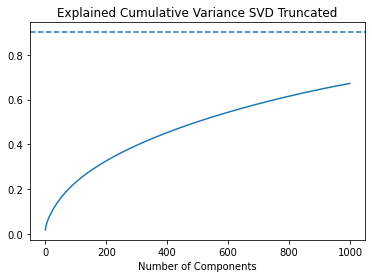

In [36]:
#Plot Explained Variabce

cumulative_exp_variance = np.cumsum(explained_variance_ratios)

fig, ax = plt.subplots()
plt.title("Explained Cumulative Variance SVD Truncated")
ax.axhline(y=0.9, linestyle='--')
plt.xlabel("Number of Components")
ax.plot(cumulative_exp_variance);



In [37]:
# calculate pearson R correlation 
corr = np.corrcoef(matrix)
corr.shape

(2961, 2961)

In [38]:
# get pattern id's into a list to be able to access indicies
pattern_ids = user_knit_pivot.index
pattern_ids_list = list(pattern_ids)

In [39]:
# choose a pattern
name_permalink = 'sheldon'
# TODO try except!

# get pattern_id in order to: get index from utility matrix
chosen_pattern_id = metadata['pattern_id'][metadata['name_permalink'] ==name_permalink].values[0]

# get index from utility matrix
chosen_patten_index = pattern_ids_list.index(chosen_pattern_id) #24

# get correlations from utility matrix
correlations = corr[pattern_ids_list.index(chosen_pattern_id)]#[0.51884817, 0.62498835, 0.32851777, .

# To sort patterns
zipped =zip(pattern_ids_list,correlations)
sorted_similar_patterns = sorted(zipped, key = lambda x: x[1], reverse=True)


# print("final list - ", str(res))

In [40]:
closest_indices = sorted_similar_patterns[:20]

pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    if i == 0:
        print('Recommendations for {0} :\n'.format(get_pattern_name_from_pattern_id(closest_indices[i][0])))
    pattern_ids.append(closest_indices[i][0])
    ordered_indices.append(get_index_from_pattern_id(closest_indices[i][0]))
#     print(f'{get_pattern_name_from_pattern_id(closest_indices[i][0])} - {closest_indices[i][1]}')
    print('{0}: {1} {2}, with distance of: {3}'
                .format(i, closest_indices[i][0], get_pattern_name_from_pattern_id(closest_indices[i][0]), closest_indices[i][1]))

closest_df = metadata.loc[ordered_indices]
closest_df 


Recommendations for sheldon :

0: 1080 sheldon, with distance of: 1.0
1: 1958 bubby, with distance of: 0.2517157214376735
2: 744 nautie, with distance of: 0.19628562513520348
3: 990 pasha, with distance of: 0.19596051551301108
4: 1192 cardigan-for-merry, with distance of: 0.19388709833896398
5: 113145 steggie, with distance of: 0.1839015566304662
6: 84314 morgan-4, with distance of: 0.18204639732585196
7: 767 katja, with distance of: 0.18173065970629218
8: 6023 harry-bear, with distance of: 0.17902631581162926
9: 46485 mary-jane-slippers-4, with distance of: 0.17757345899163562
10: 787 kate, with distance of: 0.17470394143811832
11: 2927 blu, with distance of: 0.15789173320668295
12: 2302 tit-bits, with distance of: 0.15504893492232302
13: 171113 duck-6, with distance of: 0.1519981721392165
14: 104973 smitten-5, with distance of: 0.15082718890903463
15: 364 peapod-baby-set, with distance of: 0.14980491667215753
16: 225693 dino-cap, with distance of: 0.14808525618500945
17: 86363 sexy-v

,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
2100,1080,Sheldon,sheldon,13584,4117,4.428326,1744.0,4.394948,3893,1623.0,toys,False,https://images4-g.ravelrycache.com/uploads/cas...,"[{'id': 3, 'us': '3 ', 'metric': 3.25, 'us_ste...","['textured', 'seamed', '3-dimensional', 'writt...",NaN,220.0,2006/12/01 00:00:00 -0500,25.0,4.0,True,True,"['animal', 'softies', 'toysandhobbies']",Sport (12 wpi)
18162,1958,Bubby,bubby,1734,707,3.272464,345.0,4.062696,501,319.0,toys,False,https://images4-g.ravelrycache.com/uploads/kni...,"[{'id': 3, 'us': '3 ', 'metric': 3.25, 'us_ste...","['modular', 'written-pattern', 'in-the-round']",NaN,50.0,2005/09/01 00:00:00 -0400,24.0,4.0,True,True,"['animal', 'softies', 'toysandhobbies']",Aran / Worsted
4824,744,Nautie,nautie,4657,939,3.593182,440.0,4.366995,1289,406.0,toys,False,https://images4-g.ravelrycache.com/uploads/not...,"[{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...","['textured', 'written-pattern', 'icord', 'in-t...",NaN,120.0,2006/03/01 00:00:00 -0500,22.0,4.0,True,True,"['animal', 'softies', 'toysandhobbies']",Aran / Worsted
7835,990,Pasha,pasha,5227,920,3.404018,448.0,4.250000,1423,412.0,toys,False,https://images4-f.ravelrycache.com/uploads/cas...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['seamed', 'written-pattern', 'worked-flat', '...",NaN,NaN,2004/12/01 00:00:00 -0500,20.0,4.0,True,True,"['animal', 'softies', 'toysandhobbies']",Worsted (9 wpi)
7856,1192,Cardigan for Merry,cardigan-for-merry,16006,688,4.909804,255.0,4.265560,3125,241.0,baby,True,https://images4-g.ravelrycache.com/uploads/ann...,"[{'id': 20, 'us': '2½', 'metric': 3.0, 'us_ste...","['unisex', 'baby', 'toddler', 'cables', 'hood'...",770.0,660.0,2007/05/02 21:33:00 -0400,26.0,4.0,False,False,"['cardigan', 'sweater', 'clothing']",Sport (12 wpi)
3696,113145,Steggie,steggie,6427,687,4.097561,246.0,4.467532,1313,231.0,child,True,https://images4-g.ravelrycache.com/uploads/jul...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['unisex', 'toddler', 'child', 'hood', 'seamed...",1155.0,847.0,2009/03/01 00:00:00 -0500,18.0,4.0,True,True,"['cardigan', 'sweater', 'clothing']",Aran (8 wpi)
5260,84314,Morgan,morgan-4,5527,729,5.391720,314.0,4.212014,1439,283.0,hat,True,https://images4-g.ravelrycache.com/flickr/2/7/...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['unisex', 'teen', 'adult', 'negative-ease', '...",480.0,240.0,2008/01/01 00:00:00 -0500,19.0,4.0,True,True,"['billed', 'hat', 'accessories']",DK (11 wpi)
7816,767,Katja,katja,1961,652,2.490854,328.0,4.031847,459,314.0,baby,True,https://images4-g.ravelrycache.com/uploads/cas...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['female', 'baby', 'toddler', 'icord', 'seamle...",360.0,180.0,2006/03/01 00:00:00 -0500,20.0,4.0,True,True,"['sleeveless-top', 'tops', 'clothing']",Worsted (9 wpi)
2112,6023,Harry Bear,harry-bear,4280,791,3.418868,265.0,4.406250,887,256.0,toys,False,https://images4-f.ravelrycache.com/uploads/mck...,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...","['seamed', 'short-rows', 'written-pattern', 'w...",229.0,77.0,2007/06/07 17:22:41 -0400,14.0,4.0,True,True,"['animal', 'softies', 'toysandhobbies']",Bulky (7 wpi)
30742,46485,Mary Jane Slippers,mary-jane-slippers-4,5956,609,2.916667,240.0,4.113122,1576,221.0,other,False,https://images4-f.ravelrycache.com/uploads/pur...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['female', 'adult', 'textured', 'icord', 'writ...",450.0,225.0,2008/01/01 00:00:00 -0500,20.0,4.0,True,True,"['slippers', 'feet-legs', 'accessories']",Worsted (9 wpi)


In [41]:
closest_df[0:15].photos_url.tolist()

['https://images4-g.ravelrycache.com/uploads/casey/153936026/www.knitty.com-sheldonbeauty_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/knitfish/562573263/994611936_83140b7f56_z_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/notanartist/522935902/498123961_2835707813_b_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/casey/153933529/www.knitty.com-penguinbeauty_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/annypurls/522784492/338755457_b11102f414_b_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/juliafc/6623192/steggieback_square.jpg',
 'https://images4-g.ravelrycache.com/flickr/2/7/1/2718601873/2718601873_s.jpg',
 'https://images4-g.ravelrycache.com/uploads/casey/153930801/www.knitty.com-katjaalt_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/mckenzif/304643251/harrybear_lg_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/purlsoho/566790491/2215670478_28102a5513_z_square.jpg',
 'https://images4-f.ravelrycache.co

In [42]:
# choose a pattern
name_permalink = 'soldotna-crop'
# Do try except!!! spit out something ********************

# get pattern_id in order to: get index from utility matrix
chosen_pattern_id = metadata['pattern_id'][metadata['name_permalink'] ==name_permalink].values[0]

# get index from utility matrix
chosen_patten_index = pattern_ids_list.index(chosen_pattern_id) #24

# get correlations from utility matrix
correlations = corr[pattern_ids_list.index(chosen_pattern_id)]#[0.51884817, 0.62498835, 0.32851777, .

# To sort patterns
zipped =zip(pattern_ids_list,correlations)
sorted_similar_patterns = sorted(zipped, key = lambda x: x[1], reverse=True)


# print("final list - ", str(res))

In [43]:
closest_indices = sorted_similar_patterns[:20]

pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    if i == 0:
        print('Recommendations for {0} :\n'.format(get_pattern_name_from_pattern_id(closest_indices[i][0])))
    pattern_ids.append(closest_indices[i][0])
    ordered_indices.append(get_index_from_pattern_id(closest_indices[i][0]))
#     print(f'{get_pattern_name_from_pattern_id(closest_indices[i][0])} - {closest_indices[i][1]}')
    print('{0}: {1} {2}, with distance of: {3}'
                .format(i, closest_indices[i][0], get_pattern_name_from_pattern_id(closest_indices[i][0]), closest_indices[i][1]))

closest_df = metadata.loc[ordered_indices]
closest_df 

Recommendations for soldotna-crop :

0: 910492 soldotna-crop, with distance of: 1.0
1: 1033986 jupiter-crop, with distance of: 0.41965284709020445
2: 840171 guthrie, with distance of: 0.35176320214616014
3: 841735 as-if-tee, with distance of: 0.2904318830285277
4: 960660 ghost-horses, with distance of: 0.2869877464624069
5: 1106957 feel-the-bern, with distance of: 0.2748545438331204
6: 1004479 moonwake-cowl, with distance of: 0.2693199416639271
7: 712673 cardamom-coffee, with distance of: 0.26827085656308786
8: 847398 birds-and-ships, with distance of: 0.26813582288823284
9: 965339 le-pouf-2, with distance of: 0.2564553369179498
10: 952303 stonecrop-pullover, with distance of: 0.2551446029588199
11: 861267 party-top, with distance of: 0.2427525986888777
12: 906148 koivua, with distance of: 0.2410984287774908
13: 859590 ingalls, with distance of: 0.2409248610023284
14: 1027944 summer-sorrel, with distance of: 0.238094371975095
15: 727847 radiate-5, with distance of: 0.23311255507075704


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
78279,910492,Soldotna Crop,soldotna-crop,29450,6302,3.739990,1923.0,4.701746,3859,2062.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 3, 'us': '3 ', 'metric': 3.25, 'us_ste...","['female', 'unisex', 'teen', 'adult', 'strande...",1400.0,924.0,2019/03/01 00:00:00 -0500,22.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",DK (11 wpi)
78308,1033986,Jupiter Crop,jupiter-crop,8181,616,3.810127,158.0,4.841463,997,164.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 3, 'us': '3 ', 'metric': 3.25, 'us_ste...","['female', 'unisex', 'adult', 'petite', 'plus'...",1516.0,749.0,2020/05/01 00:00:00 -0400,20.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Sport (12 wpi)
78757,840171,Guthrie,guthrie,9133,729,4.169565,230.0,4.838843,1219,242.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 2, 'us': '2 ', 'metric': 2.75, 'us_ste...","['male', 'unisex', 'adult', 'cables', 'strande...",2100.0,1250.0,2018/06/01 00:00:00 -0400,21.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",DK (11 wpi)
78758,841735,As If Tee,as-if-tee,7299,602,3.139175,194.0,4.809756,1047,205.0,tee,True,https://images4-g.ravelrycache.com/uploads/kni...,[],"['female', 'teen', 'adult', 'oversized', 'ribb...",890.0,600.0,2018/06/01 00:00:00 -0400,18.0,4.0,False,True,"['tee', 'tops', 'clothing']",Aran (8 wpi)
78380,960660,Ghost Horses,ghost-horses,9803,846,4.301075,279.0,4.793333,1347,300.0,pullover,True,https://images4-f.ravelrycache.com/uploads/boy...,"[{'id': 2, 'us': '2 ', 'metric': 2.75, 'us_ste...","['unisex', 'teen', 'adult', 'stranded', 'seaml...",2600.0,1080.0,2019/08/01 00:00:00 -0400,24.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Sport (12 wpi)
78326,1106957,Feel the Bern,feel-the-bern,7703,699,3.288557,201.0,4.772093,1071,215.0,pullover,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['adult', 'stranded', 'seamless', 'short-rows'...",1256.0,591.0,2021/01/01 00:00:00 -0500,18.0,4.0,True,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
102823,1004479,Moonwake Cowl,moonwake-cowl,8149,753,3.566327,196.0,4.904306,1033,209.0,shawl,True,https://images4-f.ravelrycache.com/uploads/dre...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['straight', 'moebius', 'stranded', 'kitchener...",NaN,500.0,2020/02/01 00:00:00 -0500,20.0,4.0,False,True,"['cowl', 'neck-torso', 'accessories']",Worsted (9 wpi)
104181,712673,Cardamom Coffee,cardamom-coffee,5509,674,3.125000,208.0,4.883621,748,232.0,child,True,https://images4-g.ravelrycache.com/uploads/boy...,"[{'id': 2, 'us': '2 ', 'metric': 2.75, 'us_ste...","['child', 'teen', 'adult', 'ribbed', 'stranded...",240.0,180.0,2016/12/01 00:00:00 -0500,30.0,4.0,False,True,"['beanie-toque', 'hat', 'accessories']",Fingering (14 wpi)
103200,847398,Birds and Ships,birds-and-ships,6101,604,2.713483,178.0,4.772487,786,189.0,shawl,True,https://images4-f.ravelrycache.com/uploads/boy...,"[{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...","['male', 'female', 'unisex', 'lace', 'one-piec...",370.0,320.0,2018/08/01 00:00:00 -0400,22.0,4.0,False,True,"['cowl', 'neck-torso', 'accessories']",Fingering (14 wpi)
78382,965339,Le Pouf,le-pouf-2,8670,700,2.852632,190.0,4.723618,1144,199.0,cardigan,True,https://images4-f.ravelrycache.com/uploads/Hed...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['female', 'unisex', 'raglan-sleeve', 'one-pie...",1750.0,1094.0,2019/09/01 00:00:00 -0400,21.0,4.0,True,True,"['cardigan', 'sweater', 'clothing']",Fingering (14 wpi)


In [44]:
closest_df[0:15].photos_url.tolist()

['https://images4-g.ravelrycache.com/uploads/boylandknitworks/612664255/Attachment-1_2_square.jpeg',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/703258800/photo1_5_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/527619578/664C25DA-4769-4B41-9F1E-723B2881321F_square.JPG',
 'https://images4-g.ravelrycache.com/uploads/knitandcroshay/529276952/IMG_5864_square.JPG',
 'https://images4-f.ravelrycache.com/uploads/boylandknitworks/643636858/6005349B-DDCC-4C40-BF1B-5D2288407537_square.JPG',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/760172545/1A279C60-9137-4A3A-9081-C8382E9D8E2F-1_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/dreareneeknits/681249861/Cowl-10_copy_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/boylandknitworks/415136880/vsco-photo-1__8__square.jpg',
 'https://images4-f.ravelrycache.com/uploads/boylandknitworks/540810664/8AFCD194-BB7A-43DC-8AE0-FA9358FFE47E_square.jpg',
 'https://images4-f.ravel

### b) Alternating Least Squares (Using the implicit library)

So after trying the Surprise library we had used in the bootcamp and achieving 0 MAE and 0 MSE with grid search cross validation, I knew something was up.  I had replaced ratings with 0-1 for a binary approach.  But after reading the documentation, i found out that Surprise doesn't support implicit ratings. (Even though the SVDpp algorithm does).  

After some research I decided to try out the implict library. 

https://implicit.readthedocs.io/en/latest/quickstart.html


In [ ]:
pattern_details = pd.read_csv('data/consolidated_patterns.csv', low_memory=False)
df = pd.read_csv('data/less_sparse_users_patterns.csv', low_memory=False)

In [45]:
# Format data for implict algorithms
dataset = df[['user_id', 'pattern_ids', 'has_knit']]
dataset.columns = ['personId', 'contentId', 'has_knit']

dataset['personId'] = dataset['personId'].astype("category")
dataset['contentId'] = dataset['contentId'].astype("category")
dataset['person_id'] = dataset['personId'].cat.codes
dataset['content_id'] = dataset['contentId'].cat.codes

# Create sparse matices
sparse_content_person = sparse.csr_matrix((dataset['has_knit'].astype(float), (dataset['content_id'], dataset['person_id'])))
sparse_person_content = sparse.csr_matrix((dataset['has_knit'].astype(float), (dataset['person_id'], dataset['content_id'])))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [46]:
# fit the model 
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_content_person * alpha).astype('double')
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

#### Item-Item Recommendations

In [57]:
dataset[dataset.contentId == 88]

,personId,contentId,has_knit,person_id,content_id
0,5153610,88,1,280414,24
1,511279,88,1,124834,24
2,3146767,88,1,241370,24
3,21965,88,1,15722,24
4,55722,88,1,32493,24
...,...,...,...,...,...
1401,4830,88,1,4040,24
1402,6179,88,1,5098,24
1403,71645,88,1,38774,24
1404,422777,88,1,114824,24


In [58]:
related = model.similar_items(88) 
related

[(88, 1.0),
 (298, 0.8463393),
 (72, 0.8199508),
 (1479, 0.7989559),
 (338, 0.7686362),
 (449, 0.7595667),
 (279, 0.75695837),
 (207, 0.7472725),
 (76, 0.72788775),
 (286, 0.7162348)]

In [59]:
closest_indices = related
pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    ordered_indices.append(closest_indices[i][0])
    if i == 0:
        print('Recommendations for similar patterns to {0} {1}:\n'.format(closest_indices[i][0], metadata.iloc[closest_indices[i][0]]['name_permalink']))
    print(f"{i}: {metadata.iloc[closest_indices[i][0]]['name_permalink']} with distance of: {closest_indices[i][1]}")

closest_df = metadata.iloc[ordered_indices]
closest_df 

Recommendations for similar patterns to 88 foxy--wolfie:

0: foxy--wolfie with distance of: 1.0
1: rainbow-twist-2 with distance of: 0.8463392853736877
2: cobblestone-7 with distance of: 0.8199508190155029
3: lanesplitter-skirt with distance of: 0.7989559173583984
4: moderne-log-cabin-blanket with distance of: 0.7686362266540527
5: angee with distance of: 0.7595667243003845
6: big-bad-baby-blanket with distance of: 0.7569583654403687
7: lina with distance of: 0.7472724914550781
8: cascade-christmas-stocking with distance of: 0.727887749671936
9: pogona with distance of: 0.7162348031997681


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
222,373102,Foxy & Wolfie,foxy--wolfie,17169,1357,4.427461,386.0,4.450000,2192,380.0,child,True,https://images4-f.ravelrycache.com/uploads/blo...,"[{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...","['unisex', 'toddler', 'child', 'teen', 'adult'...",143.0,91.0,2013/01/01 00:00:00 -0500,18.0,4.0,False,True,"['beanie-toque', 'hat', 'accessories']",Aran (8 wpi)
932,378803,Rainbow twist,rainbow-twist-2,5109,815,2.109929,282.0,4.450704,807,284.0,shawl,True,https://images4-g.ravelrycache.com/uploads/tha...,"[{'id': 15, 'us': '17 ', 'metric': 12.0, 'us_s...","['unisex', 'teen', 'adult', 'kitchener', 'prov...",90.0,80.0,2013/01/01 00:00:00 -0500,8.5,4.0,True,True,"['cowl', 'neck-torso', 'accessories']",Super Bulky (5-6 wpi)
205,14617,Cobblestone,cobblestone-7,19428,3521,2.849423,1647.0,4.485568,3678,1559.0,pullover,True,https://images4-f.ravelrycache.com/uploads/bro...,"[{'id': 8, 'us': '8 ', 'metric': 5.0, 'us_stee...","['male', 'unisex', 'bottom-up', 'in-the-round'...",1870.0,1210.0,2007/01/01 00:00:00 -0500,18.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)
79948,188691,Lanesplitter Skirt,lanesplitter-skirt,15813,3785,2.116350,1315.0,4.561921,3685,1187.0,skirt,True,https://images4-f.ravelrycache.com/uploads/kni...,"[{'id': 10, 'us': '10 ', 'metric': 6.0, 'us_st...","['female', 'negative-ease', 'stripes', 'seamed...",1098.0,638.0,2010/07/01 00:00:00 -0400,16.0,4.0,True,True,"['skirt', 'clothing']",Aran (8 wpi)
1204,1700,Moderne Log Cabin Blanket,moderne-log-cabin-blanket,6776,2039,1.933094,837.0,4.346561,1605,756.0,blanket,False,https://images4-g.ravelrycache.com/uploads/gre...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['reversible', 'one-piece', 'seamless', 'recta...",NaN,3648.0,2006/03/01 00:00:00 -0500,22.0,4.0,False,False,"['throw', 'blanket', 'home']",DK (11 wpi)
1750,112783,Angee,angee,899,1652,3.284337,830.0,4.473618,476,796.0,socks,True,https://images4-f.ravelrycache.com/uploads/Lis...,"[{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...","['unisex', 'teen', 'adult', 'negative-ease', '...",578.0,289.0,2009/04/01 00:00:00 -0400,32.0,4.0,False,False,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
900,568,Big Bad Baby Blanket,big-bad-baby-blanket,2188,3510,1.794904,1570.0,4.242754,500,1380.0,blanket,False,https://images4-f.ravelrycache.com/uploads/pra...,"[{'id': 9, 'us': '9 ', 'metric': 5.5, 'us_stee...","['reversible', 'textured', 'one-piece', 'seaml...",NaN,1440.0,2004/09/01 00:00:00 -0400,18.0,4.0,False,False,"['babyblanket', 'blanket', 'home']",Aran (8 wpi)
611,58564,Lina,lina,13731,2118,3.002516,795.0,4.400262,3000,762.0,hat,True,https://images4-f.ravelrycache.com/uploads/jok...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['unisex', 'teen', 'adult', 'cables', 'ribbed'...",NaN,NaN,2008/03/01 00:00:00 -0500,22.0,4.0,True,True,"['beanie-toque', 'hat', 'accessories']",DK (11 wpi)
209,65956,Cascade Christmas Stocking,cascade-christmas-stocking,8952,1566,3.619318,352.0,4.441261,1511,349.0,home,False,https://images4-g.ravelrycache.com/uploads/min...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['unisex', 'top-cuff-down', 'ribbed', 'strande...",2200.0,880.0,2012/08/01 00:00:00 -0400,18.0,4.0,True,True,"['christmasstocking', 'decorative', 'home']",Worsted (9 wpi)
910,185648,Pogona,pogona,13436,2992,2.344206,1165.0,4.481938,2964,1135.0,shawl,True,https://images4-g.ravelrycache.com/flickr/4/7/...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['unisex', 'teen', 'adult', 'textured', 'one-p...",NaN,380.0,2010/07/01 00:00:00 -0400,22.0,4.0,False,True,"['shawl-wrap', 'neck-torso', 'accessories']",Fingering (14 wpi

#### User Recommendations

In [48]:
user_items = sparse_person_content
userid = 264731 # This is my id
recommendations = model.recommend(userid, user_items)

recommendations

[(1224, 0.15384823),
 (605, 0.15064034),
 (1395, 0.12059453),
 (361, 0.11879735),
 (1401, 0.11014099),
 (1541, 0.105330035),
 (1357, 0.10421778),
 (2228, 0.10276949),
 (2794, 0.102627866),
 (19, 0.09826541)]

In [49]:
# print out recomendations
closest_indices = recommendations
pattern_ids = []
ordered_indices = []
for i in range(len(closest_indices)):
    ordered_indices.append(closest_indices[i][0])
    if i == 0:
        
        print('Recommendations for user {0} (me) :\n'.format(userid))
    print(f"{i}: {metadata.iloc[closest_indices[i][0]]['name_permalink']} with distance of: {closest_indices[i][1]}")

closest_df = metadata.iloc[ordered_indices]
closest_df 

Recommendations for user 264731 (me) :

0: zweig with distance of: 0.15384823083877563
1: kelp-4 with distance of: 0.1506403386592865
2: portage-4 with distance of: 0.12059453129768372
3: medano-beach with distance of: 0.11879734694957733
4: arwen-6 with distance of: 0.11014098674058914
5: vanilla-3 with distance of: 0.10533003509044647
6: cullum with distance of: 0.1042177826166153
7: heirloom-hats-for-newborns with distance of: 0.10276948660612106
8: julias-cabled-headband with distance of: 0.10262786597013474
9: brick-2 with distance of: 0.09826540946960449


,pattern_id,name,name_permalink,favorites_count,projects_count,difficulty_average,difficulty_count,rating_average,queued_projects_count,rating_count,pattern_type_names,pattern_type_clothing,photos_url,pattern_needle_sizes,pattern_attributes,yardage_max,yardage,generally_available,gauge,gauge_divisor,free,downloadable,categories,yarn_weight_description
78261,778932,Zweig,zweig,41533,6762,4.107805,2050.0,4.811786,6047,2189.0,pullover,True,https://images4-f.ravelrycache.com/uploads/Kni...,"[{'id': 5, 'us': '5 ', 'metric': 3.75, 'us_ste...","['female', 'adult', 'lace', 'textured', 'stran...",2300.0,1100.0,2017/10/01 00:00:00 -0400,24.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Fingering (14 wpi)
2758,125553,Kelp,kelp-4,3694,659,2.807947,302.0,4.349481,1140,289.0,socks,True,https://images4-f.ravelrycache.com/uploads/Gol...,"[{'id': 21, 'us': '1½', 'metric': 2.5, 'us_ste...","['female', 'unisex', 'adult', 'top-cuff-down',...",375.0,350.0,2009/06/01 00:00:00 -0400,7.5,1.0,True,True,"['mid-calf', 'socks', 'feet-legs', 'accessories']",Fingering (14 wpi)
78850,537949,Portage,portage-4,35701,1558,4.432570,393.0,4.618483,5562,422.0,cardigan,True,https://images4-f.ravelrycache.com/uploads/dan...,"[{'id': 5, 'us': '5 ', 'metric': 3.75, 'us_ste...","['adult', 'negative-ease', 'cables', 'ribbed',...",2975.0,1700.0,2014/11/01 00:00:00 -0400,20.0,4.0,False,True,"['cardigan', 'sweater', 'clothing']",DK (11 wpi)
1234,124175,Medano Beach,medano-beach,11625,921,2.267974,306.0,4.290657,1985,289.0,bag,False,https://images4-g.ravelrycache.com/flickr/3/5/...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['seamless', 'bottom-up', 'in-the-round']",NaN,550.0,2009/05/23 18:39:22 -0400,20.0,4.0,True,True,"['tote', 'bag', 'accessories']",DK (11 wpi)
78858,773939,Arwen,arwen-6,11141,738,3.456140,285.0,4.829508,1245,305.0,pullover,True,https://images4-f.ravelrycache.com/uploads/lil...,"[{'id': 20, 'us': '2½', 'metric': 3.0, 'us_ste...","['oversized', 'bobble-or-popcorn', 'eyelets', ...",2461.0,984.0,2017/09/01 00:00:00 -0400,27.0,4.0,False,True,"['pullover', 'sweater', 'clothing']",Light Fingering
81752,106405,Vanilla,vanilla-3,8682,2251,3.003604,555.0,4.554545,1289,550.0,baby,True,https://images4-f.ravelrycache.com/uploads/tik...,"[{'id': 6, 'us': '6 ', 'metric': 4.0, 'us_stee...","['unisex', 'baby', 'newborn-size', 'toddler', ...",NaN,NaN,2009/01/01 00:00:00 -0500,NaN,4.0,False,True,"['soakers', 'clothing']",Worsted (9 wpi)
78558,733590,Cullum,cullum,21449,1245,3.422280,386.0,4.655257,2514,409.0,tee,True,https://images4-g.ravelrycache.com/uploads/qui...,"[{'id': 4, 'us': '4 ', 'metric': 3.5, 'us_stee...","['lace', 'one-piece', 'seamless', 'short-rows'...",1512.0,840.0,2017/03/01 00:00:00 -0500,24.0,4.0,False,True,"['tee', 'tops', 'clothing']",Fingering (14 wpi)
105098,193770,Heirloom Hats for Newborns,heirloom-hats-for-newborns,7702,1165,1.764310,297.0,4.575251,910,299.0,baby,True,https://images4-f.ravelrycache.com/uploads/pur...,"[{'id': 2, 'us': '2 ', 'metric': 2.75, 'us_ste...","['unisex', 'baby', 'newborn-size', 'tassel', '...",120.0,NaN,2013/10/01 00:00:00 -0400,8.0,1.0,True,True,"['beanie-toque', 'hat', 'accessories']",Light Fingering
116617,106410,Julia's Cabled Headband,julias-cabled-headband,5464,687,2.636364,253.0,4.622807,872,228.0,hat,True,https://images4-g.ravelrycache.com/flickr/3/2/...,"[{'id': 7, 'us': '7 ', 'metric': 4.5, 'us_stee...","['female', 'adult', 'cables', 'textured', 'one...",66.0,55.0,2009/01/01 00:00:00 -0500,18.0,4.0,True,True,"['headband', 'headwear', 'accessories']",Aran (8 wpi)
21,294917,Brick,brick-2,26703,2448,2.492492,666.0,4.477918,4185,634.0,pullover,True,https://images4-g.ravelrycache.com/flickr/6/4/...,"[{'id': 9, 'us': '9 ', 'metric': 5.5, 'us_stee...","['seamless', 'top-down', 'in-the-round', 'adul...",1800.0,680.0,2012/01/23 02:21:50 -0500,18.0,4.0,True,True,"['pullover', 'sweater', 'clothing']",Worsted (9 wpi)


In [50]:
closest_df.photos_url.tolist()

['https://images4-f.ravelrycache.com/uploads/Knitosophy/474367583/DSC02703_square.JPG',
 'https://images4-f.ravelrycache.com/uploads/GoldenIris/305007226/DSC_0076_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/dandiliongrl/266702793/IMG_6033_crope_square.jpg',
 'https://images4-g.ravelrycache.com/flickr/3/5/5/3557159945/3557159945_s.jpg',
 'https://images4-f.ravelrycache.com/uploads/lilalu/470070510/IMG_0370-001_square.JPG',
 'https://images4-f.ravelrycache.com/uploads/tikki/5208884/vanilla2_square.jpg',
 'https://images4-g.ravelrycache.com/uploads/quinceandco/433274957/quince-co-cullum-isabell-kraemer-knitting-pattern-sparrow-1_square.jpg',
 'https://images4-f.ravelrycache.com/uploads/purlsoho/190780129/line-weight-heirloom-hats-600-1-2_square.jpg',
 'https://images4-g.ravelrycache.com/flickr/3/2/3/3235656610/3235656610_s.jpg',
 'https://images4-g.ravelrycache.com/flickr/6/4/4/6444117953/6444117953_s.jpg']

Actually these look pretty great!  I think I'll be casting on "Portage" cardigan after this week!

### Next Steps:
Tune the model based filters, but be mindful these can overfit:
https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919